In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Khai báo thư viện

In [ ]:
from IPython.display import display, FileLink
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import utils, layers, backend as K, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, TensorBoard

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

from IPython.display import FileLink
from IPython import display
import pandas as pd

from sklearn.metrics import classification_report
import cv2

from PIL import Image
import os
import shutil
from pathlib import Path

import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

import random
import tensorboard
from datetime import datetime
from packaging import version
import copy
# import visualkeras
from PIL import Image

import shutil

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
SEED_VALUE = 42
BATCH_SIZE = 32
N_EPOCH = 50
N_CLASSES = 6
VERBOSE = 1

IMG_ROWS = 224
IMG_COLS = 224
IMG_CHANNELS = 3



In [ ]:

cur_dir = '/content/drive/MyDrive/Gr3_Fabric_Classification'
os.chdir(cur_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/MyDrive/Gr3_Fabric_Classification


In [ ]:
# Seeding everything
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

## Import train & validation set


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Gr3_Fabric_Classification/data/model_data/train_df.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Gr3_Fabric_Classification/data/model_data/validation_df.csv')


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Gr3_Fabric_Classification/data/prepare/test.csv')


In [ ]:
label_mapping = {
    'Cotton': 0,
    'Denim': 1,
    'Nylon': 2,
    'Polyester': 3,
    'Silk': 4,
    'Wool': 5
}

train_df['Label'] = train_df['Label'].map(label_mapping)
validation_df['Label'] = validation_df['Label'].map(label_mapping)
test_df['Label'] = test_df['Label'].map(label_mapping)

print("Mã hóa nhãn trong train_df:")
print(train_df['Label'].value_counts())

print("Mã hóa nhãn trong validation_df:")
print(validation_df['Label'].value_counts())

print("Mã hóa nhãn trong test_df:")
print(test_df['Label'].value_counts())


Mã hóa nhãn trong train_df:
Label
0    1505
1    1505
2    1505
3    1505
4    1505
5    1505
Name: count, dtype: int64
Mã hóa nhãn trong validation_df:
Label
0    376
1    376
2    376
3    376
4    376
5    376
Name: count, dtype: int64
Mã hóa nhãn trong test_df:
Label
0    471
3    181
1    130
5     72
2     45
4     40
Name: count, dtype: int64


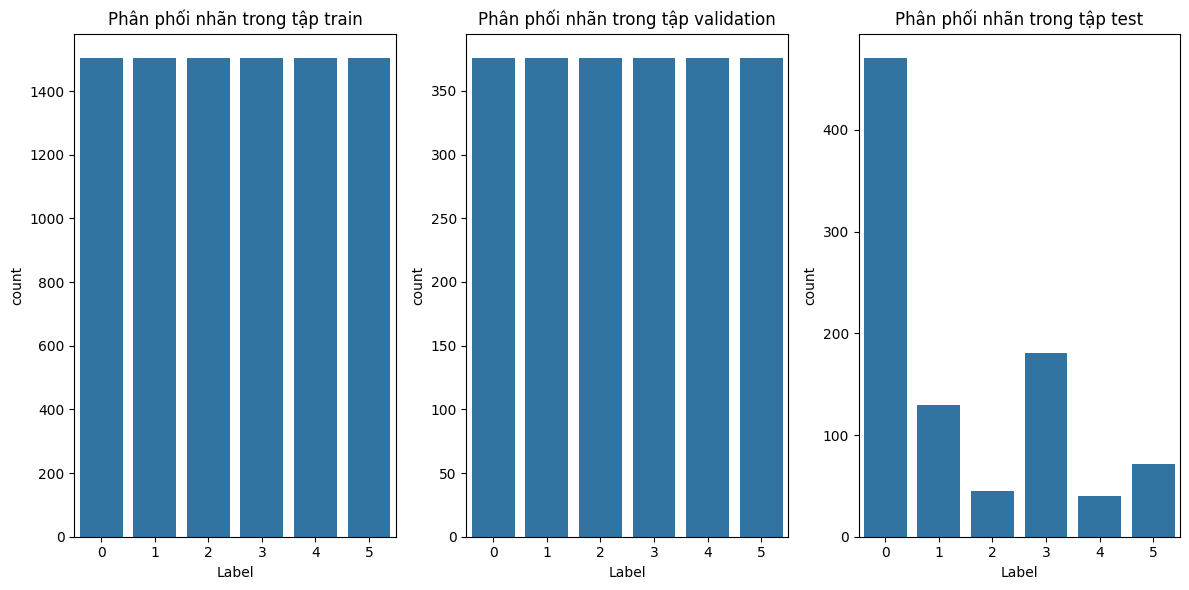

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Label', data=train_df)
plt.title('Label Distribution in Training Set')

plt.subplot(1, 3, 2)
sns.countplot(x='Label', data=validation_df)
plt.title('Label Distribution in Validation Set')

plt.subplot(1, 3, 3)
sns.countplot(x='Label', data=test_df)
plt.title('Label Distribution in Test Set')

plt.tight_layout()
plt.show()


In [ ]:
train_df['Label'] = train_df['Label'].astype(str)
validation_df['Label'] = validation_df['Label'].astype(str)

In [ ]:
test_df['Label'] = test_df['Label'].astype(str)

In [ ]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sử dụng hàm tiền xử lý của ResNet50
train_datagenerator = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

training_data = train_datagenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS),  # downsampling the images
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED_VALUE,
)


Found 9030 validated image filenames belonging to 6 classes.


In [ ]:
validation_datagenerator = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

# Chuẩn bị dữ liệu validation
validation_data = validation_datagenerator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS),
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED_VALUE
)


Found 2256 validated image filenames belonging to 6 classes.


In [ ]:
test_datagenerator = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

test_data = test_datagenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS),
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED_VALUE
)

Found 939 validated image filenames belonging to 6 classes.


# Feature Extraction with ResNet50

In [ ]:
import time
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import numpy as np
import os

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))

# Create a new model that outputs the features from the last layer of the ResNet50 model
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(data, model, dataset_type):
    """
    Extracts features from a dataset using a given model and saves them to a specified path.
    dataset_type: type of the dataset (train, validation, test)
    """

    features = []
    labels = []
    start_time = time.time()
    total_samples = len(data.filenames)  # this is the total samples (images)
    processed_samples = 0

    # Tạo thư mục nếu chưa tồn tại
    save_path = f"/content/drive/MyDrive/Gr3_Fabric_Classification/data/image_extraction/resnet50_extraction/{dataset_type}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Use data.n to get the number of batches rather than len(data.filenames)
    for i in range(len(data)):
        # get the batch of images and labels
        image, label = data[i]
        feature = model.predict(image)
        # extend features and labels instead of append
        features.extend(feature)
        labels.extend(label)
        processed_samples += len(image)  # increase by size of current batch

        elapsed_time = time.time() - start_time
        remaining_samples = total_samples - processed_samples
        estimated_time_remaining = (elapsed_time / processed_samples) * remaining_samples if processed_samples > 0 else 0

        print(f"Processed {processed_samples}/{total_samples} samples. Estimated time remaining: {estimated_time_remaining:.2f} seconds")

    features = np.array(features)
    labels = np.array(labels)

    # Lưu dữ liệu sau khi trích xuất với tên file bao gồm thông tin tập dữ liệu
    np.save(f"{save_path}/{dataset_type}_features.npy", features)
    np.save(f"{save_path}/{dataset_type}_labels.npy", labels)

    print(f"Features extracted and saved to: {save_path}")

# Extract features for train, validation, and test sets
extract_features(training_data, model, 'train')
extract_features(validation_data, model, 'validation')
extract_features(test_data, model, 'test')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processed 1056/2256 samples. Estimated time remaining: 428.26 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processed 1088/2256 samples. Estimated time remaining: 416.32 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processed 1120/2256 samples. Estimated time remaining: 404.56 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed 1152/2256 samples. Estimated time remaining: 393.39 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Processed 1184/2256 samples. Estimated time remaining: 381.22 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed 1216/2256 samples. Estimated time remaining: 369.01 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Processed 1248/2256 samples. Estimated time remaining: 357.33 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed 1280/2256 samples. Estimated time remaining: 345.43 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed 1312/2256 samples. Estimated time remaining: 335.22 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 